In [1]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

In [26]:
gsmf = holo.sam.GSMF_Schechter()        # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()          # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()          # Galaxy Merger Time           (GMT)
# for reference MM13 vals: mamp=MSOL * 10.0 ** 8.46, mplaw=1.05, mref=1.0e11*MSOL, bulge_mfrac=0.615, scatter_dex=0.34

mmbulge = holo.relations.MMBulge_Standard(mamp=MSOL * 10.0 ** 8.7, mplaw=1.05, mref=1.0e11*MSOL, bulge_mfrac=0.615, scatter_dex=0.34) # M-MBulge Relation            (MMB)

sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [27]:
fobs = utils.nyquist_freqs(15.0*YR, 0.1*YR)
gwb = sam.gwb(fobs, realize=1)
# print(fobs.shape, utils.stats(fobs))
# print(gwb.shape, utils.stats(gwb))

(150,) 2.11e-09, 1.69e-08, 5.13e-08, 1.59e-07, 2.68e-07, 3.02e-07, 3.17e-07
(149,) 1.21e-17, 2.51e-17, 4.64e-17, 1.28e-16, 5.51e-16, 1.66e-15, 5.30e-15


In [28]:
# --- Create Fake NANOGrav Dataset TODO: get better approximation of measurement
measured_amp = 1.0e-15
measured_slope = -2.0/3.0
measured_freqs = kale.utils.midpoints(fobs * YR)
measured_spectrum = measured_amp * np.power(measured_freqs, measured_slope)
measured_uncertainties = measured_spectrum * 0.2

In [29]:
# --- Calculate chi^2. TODO: rearrange and loop over mamp values
chisq = np.sum(((gwb - measured_spectrum)/measured_uncertainties)**2)
print(chisq)

1762.002632483494


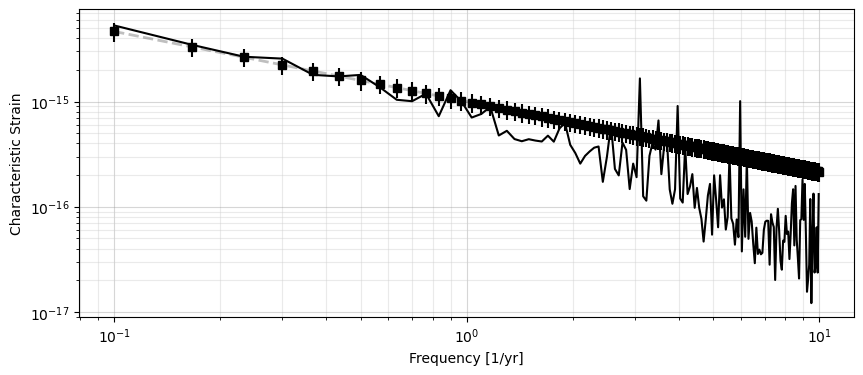

In [30]:
# ---- Plot GWB ---- TODO: plot all realizations color-coded by mamp value
fig, ax = plot.figax(xlabel='Frequency [1/yr]', ylabel='Characteristic Strain')
# ax.set(xlabel='Frequency [1/yr]', ylabel='Characteristic Strain')
# ax.grid(alpha=0.2)

xx = fobs * YR
xx = kale.utils.midpoints(xx) 
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, measured_spectrum, 'k--', alpha=0.25, lw=2.0)
ax.errorbar(xx, measured_spectrum, measured_uncertainties, c='k', linestyle='none', marker='s')
# ax.plot(xx, np.median(gwb, axis=-1), 'k-')
ax.plot(xx, gwb, 'k-')
# for pp in [50, 98]:
#     percs = pp / 2
#     percs = [50 - percs, 50 + percs]
#     ax.fill_between(xx, *np.percentile(gwb, percs, axis=-1), alpha=0.25, color='b')

plt.show()